In [ ]:
import os
import sys
import pypsa
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

sys.path.append(str(Path.cwd()))
from plotting_constants import colors

from data_path import DATA_PATH

idx = pd.IndexSlice

In [ ]:
base = Path(DATA_PATH)
base

c:\Users\lukas\OneDrive\Desktop\projects\egs\cluster_data\breyer_sweep


In [3]:
files = [
    'nodal_capacities.csv',
    'nodal_geothermal_stats.csv',
    'nodal_loads.csv',
    'costs.csv',
    'capacities.csv',
    'supply.csv',
    'metrics.csv',
    'supply_energy.csv',
]

In [9]:
# path1 = base / 'sensitivity_renewable_costs_heat'
# path2 = base / 'sensitivity_renewable_costs_elec'
path1 = base / 'sensitivity_emissions_elec'
path2 = base / 'sensitivity_emissions_heat'
target = base / 'sensitivity_emissions_all'

In [10]:
index_cols = {
    'nodal_capacities.csv': list(range(3)),
    'nodal_geothermal_stats.csv': list(range(2)),
    'nodal_loads.csv': list(range(2)),
    'costs.csv': list(range(3)),
    'capacities.csv': list(range(2)),
    'supply.csv': list(range(3)),
    'supply_energy.csv': list(range(3)),
    'metrics.csv': 0,
}

for file in files:
    df1 = pd.read_csv(path1 / file, index_col=index_cols[file], header=list(range(9)))
    df2 = pd.read_csv(path2 / file, index_col=index_cols[file], header=list(range(9)))

    pd.concat([df1, df2], axis=1).to_csv(target / file)

In [11]:
def get_capacity_or_cost(path, mode, name):
    """Obtains base numbers for elec, dh, chp. For now these are installed borehole capacity
    and total system cost."""

    assert mode in ['capacity', 'cost']
    fn = 'capacities.csv' if mode == 'capacity' else 'metrics.csv'

    if mode == 'capacity':
        index_cols = [0,1]
    elif mode == 'cost':
        index_cols = 0

    df = pd.read_csv(
        path / fn,
        index_col=index_cols,
        header=list(range(9))
        )

    flex = 'static'
    waste_heat = 'True'
    dh_share = '0.3'
    ll = 'v1.0'
    so = 'Co2L0-3H-T-H-B-I-solar+p3-dist1'

    if name == 'flex':
        flex = 'flex'
    elif name == 'waste_heat':
        waste_heat = 'False'

    elif 'dh_share' in name:
        dh_share = name.split('-')[-1]
    elif 'trans' in name:
        ll = name.split('-')[-1]
    elif 'rn_costs' in name:
        c = name.split('-')[-1]
        template = '-wind+c{}-solar+c{}-ror+c{}-hydro+c{}-nuclear+c{}'
        so += template.format(c,c,c,c,c)
    elif 'emissions' in name:
        so = 'Co2L0.1-3H-T-H-B-I-solar+p3-dist1'

    if mode == 'capacity':
        if name != 'waste_heat' and 'dh_share' not in name:
            elec = df.loc[
                    idx['links', ['injection geothermal heat']]
                    ,
                    idx[:,ll,so,:,'2050',['elec'], flex, dh_share, waste_heat],
                    ]
        else: elec = pd.DataFrame()

        ss = pd.concat((
            df.loc[
                idx['links', ['injection geothermal heat']]
                ,
                idx[:,ll,so,:,'2035',['chp','dh'], flex, dh_share, waste_heat],
                ],
            elec
        )).T.fillna(0).sum(axis=1)
    
    elif mode == 'cost':
        if name != 'waste_heat' and 'dh_share' not in name:
            elecss = df.loc[
                ["total costs"],
                idx[:,ll,so,:,'2050', ['elec'], flex, dh_share, waste_heat],
                ]
        else: elecss = pd.DataFrame()

        heatss = df.loc[
            ["total costs"],
            idx[:,ll,so,:,'2035',['chp','dh'], flex, dh_share, waste_heat],
            ]

        ss = pd.concat((
            elecss,
            heatss,
        ), axis=1).T.sum(axis=1)

    ss.index = ss.index.get_level_values(5)

    ss = pd.DataFrame(ss).rename(columns={0:name}).stack()
    ss = pd.DataFrame(ss).rename(columns={0:mode}).stack()
    ss.index = ss.index.reorder_levels([2,1,0])

    return ss


data = pd.concat((
    get_capacity_or_cost(base/'joint_data', 'capacity', 'base'),
    get_capacity_or_cost(base/'joint_data', 'cost', 'base'),

    get_capacity_or_cost(base/'joint_data', 'capacity', 'flex'),
    get_capacity_or_cost(base/'joint_data', 'cost', 'flex'),

    get_capacity_or_cost(base/'sensitivity_transmission_all', 'capacity', 'trans-v1.125'),
    get_capacity_or_cost(base/'sensitivity_transmission_all', 'cost', 'trans-v1.125'),
    get_capacity_or_cost(base/'sensitivity_transmission_all', 'capacity', 'trans-v1.25'),
    get_capacity_or_cost(base/'sensitivity_transmission_all', 'cost', 'trans-v1.25'),

    get_capacity_or_cost(base/'sensitivity_waste_heat', 'capacity', 'waste_heat'),
    get_capacity_or_cost(base/'sensitivity_waste_heat', 'cost', 'waste_heat'),

    get_capacity_or_cost(base/'sensitivity_renewable_costs_all', 'capacity', 'rn_costs-0.8'),
    get_capacity_or_cost(base/'sensitivity_renewable_costs_all', 'cost', 'rn_costs-0.8'),
    get_capacity_or_cost(base/'sensitivity_renewable_costs_all', 'capacity', 'rn_costs-1.2'),
    get_capacity_or_cost(base/'sensitivity_renewable_costs_all', 'cost', 'rn_costs-1.2'),

    get_capacity_or_cost(base/'sensitivity_district_heat', 'capacity', 'dh_share-0.0'),
    get_capacity_or_cost(base/'sensitivity_district_heat', 'cost', 'dh_share-0.0'),
    get_capacity_or_cost(base/'sensitivity_district_heat', 'capacity', 'dh_share-0.6'),
    get_capacity_or_cost(base/'sensitivity_district_heat', 'cost', 'dh_share-0.6'),
    get_capacity_or_cost(base/'sensitivity_district_heat', 'capacity', 'dh_share-1.0'),
    get_capacity_or_cost(base/'sensitivity_district_heat', 'cost', 'dh_share-1.0'),

    get_capacity_or_cost(base/'sensitivity_emissions_all', 'capacity', 'emissions-0.1'),
    get_capacity_or_cost(base/'sensitivity_emissions_all', 'cost', 'emissions-0.1'),
))

In [12]:
import warnings
warnings.filterwarnings("ignore")

cap = data.loc[idx['capacity', :, :]].mul(1e-3)
cos = data.loc[idx['cost', :, :]].mul(1e-9)

base_cap = cap.loc[idx['base',:]]
base_cos = cos.loc[idx['base',:]]

for mode in ['chp', 'dh', 'elec']:

    cap.loc[idx[:, [mode]]] -= cap.loc[idx['base', mode]]
    cos.loc[idx[:, [mode]]] -= cos.loc[idx['base', mode]]

cap.drop('base', level=0, inplace=True)
cos.drop('base', level=0, inplace=True)

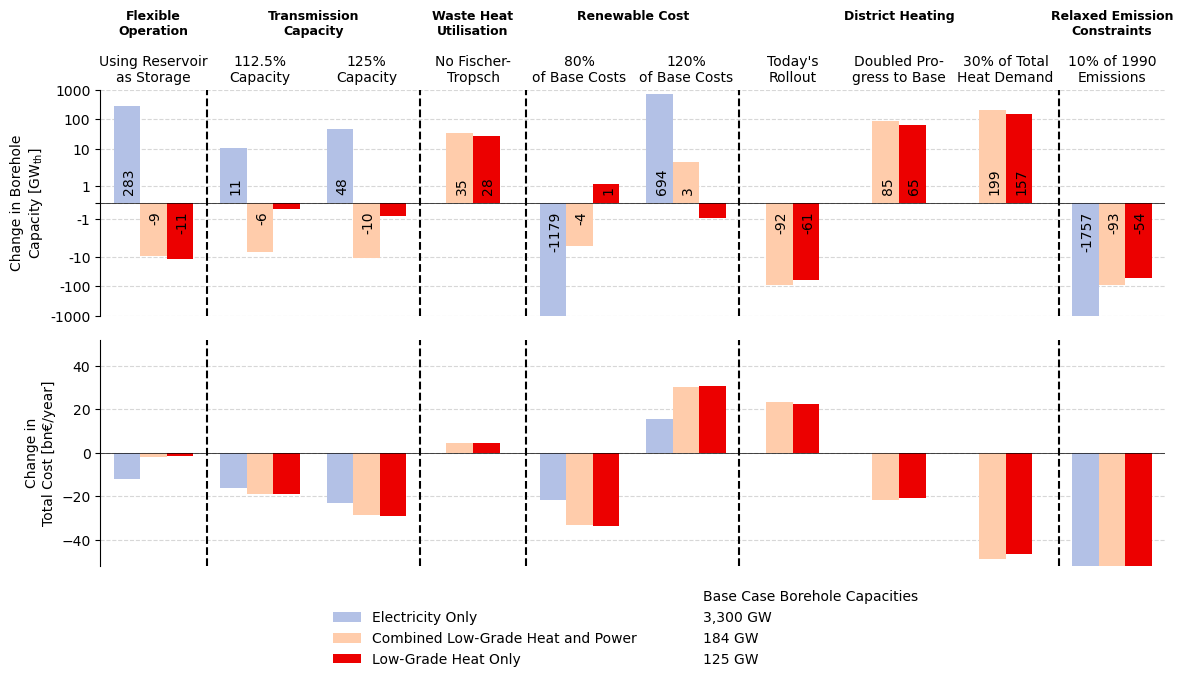

: 

In [ ]:
width = 0.25

fig, axs = plt.subplots(2, 1, figsize=(12, 7))

for i, (df, ax) in enumerate(zip([cap, cos], axs)):
    
    for j, an in enumerate(df.index.get_level_values(0).unique()):

        ss = df.loc[idx[an, :]]

        l = len(ss)

        if len(ss) == 2:
            ss = ss.loc[['chp', 'dh']]
        if len(ss) == 3:
            ss = ss.loc[['elec', 'chp', 'dh']]

        for k, (mode, val) in enumerate(ss.items()):

            x_pos = j + width * k - l/2*width + width/2
            bar = ax.bar(x_pos, val, width=width, color=colors[mode])

            if i == 0 and abs(val) > 1:
                if val > 0:
                    ax.text(x_pos + 0.02, 0.5, f'{int(val)}', 
                        rotation=90, ha='center', va='bottom')
                else:
                    ax.text(x_pos + 0.02, -0.5, f'{int(val)}', 
                        rotation=90, ha='center', va='top')

for x in [0.5, 2.5, 3.5, 5.5, 8.5]:
    for ax in axs:
        ax.axvline(x, color='black', linestyle='--')

axs[0].set_yscale('symlog')

for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim(-0.5, 9.5)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_axisbelow(True)
    ax.spines['bottom'].set_visible(False)

for x, s in zip(
    [0., 1.5, 3., 4.5, 7, 9],
    [
        'Flexible\nOperation',
        'Transmission\nCapacity',
        'Waste Heat\nUtilisation',
        'Renewable Cost',
        'District Heating',
        'Relaxed Emission\nConstraints',
    ]):
    axs[0].text(x, 5e5, s, ha='center', va='top', fontsize=9, fontweight='bold')

axs[0].set_ylim(-1000, 1000)
axs[0].set_yticklabels([f'{int(x)}' if x != 0 else '' for x in axs[0].get_yticks()])

axs[0].set_xticks([])

axs[1].set_ylim(-52, 52)

axs[0].set_xticks(
    list(range(10)),
    [
        "Using Reservoir\nas Storage",
        "112.5%\nCapacity",
        "125%\nCapacity",
        "No Fischer-\nTropsch",
        "80%\nof Base Costs",
        "120%\nof Base Costs",
        "Today's\nRollout",
        "Doubled Pro-\ngress to Base",
        "30% of Total\nHeat Demand",
        "10% of 1990\nEmissions",
    ])

axs[0].tick_params(axis='x', which='major',length=0)
axs[0].xaxis.tick_top()

axs[1].set_xticks([])

axs[0].set_ylabel('Change in Borehole\nCapacity [GW$_\mathrm{th}$]')
axs[1].set_ylabel('Change in\nTotal Cost [bn€/year]')

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

labels = [
    "",
    "Electricity Only",
    "Combined Low-Grade Heat and Power",
    "Low-Grade Heat Only",
    "Base Case Borehole Capacities",
    "3,300 GW", "184 GW", "125 GW",
]
handles = [
    Line2D([0], [0], color='w', linewidth=0.5),
    Patch(facecolor=colors['elec']),
    Patch(facecolor=colors['chp']),
    Patch(facecolor=colors['dh']),
    Line2D([0], [0], color='w', linewidth=0.5),
    Line2D([0], [0], color='w', linewidth=0.5),
    Line2D([0], [0], color='w', linewidth=0.5),
    Line2D([0], [0], color='w', linewidth=0.5),
]
axs[1].legend(
    handles,
    labels,
    bbox_to_anchor=(0.78, -0.05),
    frameon=False,
    ncol=2,
    )

plt.tight_layout()
plt.savefig("sensitivity.pdf")
plt.show()